# Makemore - MLP Version

In [739]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [740]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [741]:
len(words)

32033

In [742]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [743]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next
X, Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0] * block_size 
    for ch in w + '.': # iterates over all characters
        ix = stoi[ch] # get character in the sequence
        X.append(context) # stores the value of this context
        Y.append(ix) # build out the array y of this context
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
..... ---> e
....e ---> m
...em ---> m
..emm ---> a
.emma ---> .
olivia
..... ---> o
....o ---> l
...ol ---> i
..oli ---> v
.oliv ---> i
olivi ---> a
livia ---> .
ava
..... ---> a
....a ---> v
...av ---> a
..ava ---> .
isabella
..... ---> i
....i ---> s
...is ---> a
..isa ---> b
.isab ---> e
isabe ---> l
sabel ---> l
abell ---> a
bella ---> .
sophia
..... ---> s
....s ---> o
...so ---> p
..sop ---> h
.soph ---> i
sophi ---> a
ophia ---> .


In [744]:
X.shape, Y.shape

(torch.Size([32, 5]), torch.Size([32]))

In [745]:
g = torch.Generator().manual_seed(2147583647)
C = torch.rand((27, 2), generator=g) # look up table with 27 rows and 2 columns (each one of the 27 characters will have 2 embeddings)
# hidden layer
W1 = torch.randn((10, 100), generator=g) # we use 10 as there 5 two-dimensional embeddings, 100 is a random number of neurons
b1 = torch.randn(100, generator = g)
# output layer
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameter = [C, W1, b1, W2, b2]

In [746]:
sum(p.nelement() for p in parameter) # num of parameter in total

3881

In [747]:
for p in parameter:
    p.requires_grad = True

In [748]:
for _ in range(100):
    emb = C[X] # embedding X with C
    h = torch.tanh(emb.view(-1, 10) @ W1 + b1) # activation unit
    logits = h @ W2 + b2
    # counts = logits.exp() 
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # this gives loss the same way the previous 3 lines do
    
    # backward pass
    for p in parameter:
        p.grad = None
    loss.backward()
    # update
    for p in parameter:
        p.data += -0.1 * p.grad

print(loss.item())

0.48641979694366455


This was very easy to achieve as we only were running the model on a few examples more specifically 32 examples based off 5 words only, meaning that we are overfitting this model.

## Running the Whole Model

In [749]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next
    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size 
        for ch in w + '.': # iterates over all characters
            ix = stoi[ch] # get character in the sequence
            X.append(context) # stores the value of this context
            Y.append(ix) # build out the array y of this context
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words) # shuffle the words up
n1 = int(0.8*len(words)) 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # train
Xdev, Ydev = build_dataset(words[n1:n2]) 
Xte, Yte = build_dataset(words[n2:]) # test set


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [750]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [751]:
g = torch.Generator().manual_seed(2147583647)
C = torch.rand((27, 10), generator=g) # look up table with 27 rows and 10 columns (each one of the 27 characters will have 10 embeddings)
# hidden layer
W1 = torch.randn((30, 200), generator=g) # we use 10 as there 5 two-dimensional embeddings, 100 is a random number of neurons
b1 = torch.randn(200, generator = g)
# output layer
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameter = [C, W1, b1, W2, b2]

In [752]:
sum(p.nelement() for p in parameter) # num of parameter in total

11897

In [753]:
for p in parameter:
    p.requires_grad = True

In [754]:
# optimizes the learning rate
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # spaces it out linearly

In [755]:
lri = [] # tracks learning rate
lossi = [] # tracks losses
stepi = []

In [764]:

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # helps with choosing a random set of numbers

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # activation unit
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # this gives loss the same way the previous 3 lines do
    # print(loss.item())
    
    # backward pass
    for p in parameter:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameter:
        p.data += -lr * p.grad

    # track stats (learning rate decay)
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print(loss.item())

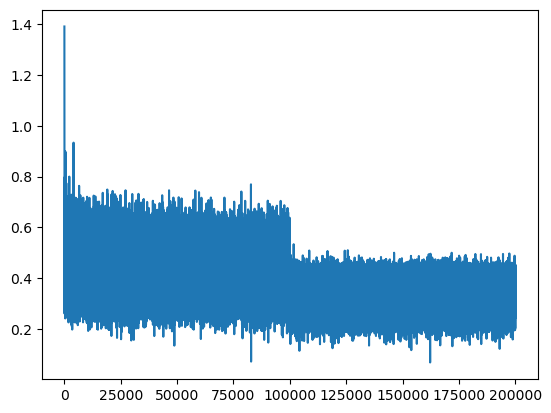

In [765]:
plt.plot(stepi, lossi)
plt.show()

In [758]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1799, grad_fn=<NllLossBackward0>)

In [759]:
# dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1966, grad_fn=<NllLossBackward0>)

It can take quite long to run the training on all 228,000+ examples, especially if we were to say this model had several layers, so a work around of this is to make this data into minibatches. The minibatches tend to make the gradient quite unreliable in comparison to using the full set.

We might have a low training loss, however, this doesn't mean that the model is good at generalization, so we have to split the model training data into a training set, testing set and validation set.

When the dev loss and the training loss are similar it means that the data is not overfitting, which is a good sign for the model showing that it has a good habit of generalization.

Furthermore, after several sets of training it can become quite obvious that the training set fails to find a better learning rate due to possible bottlenecks caused by the embeddings.

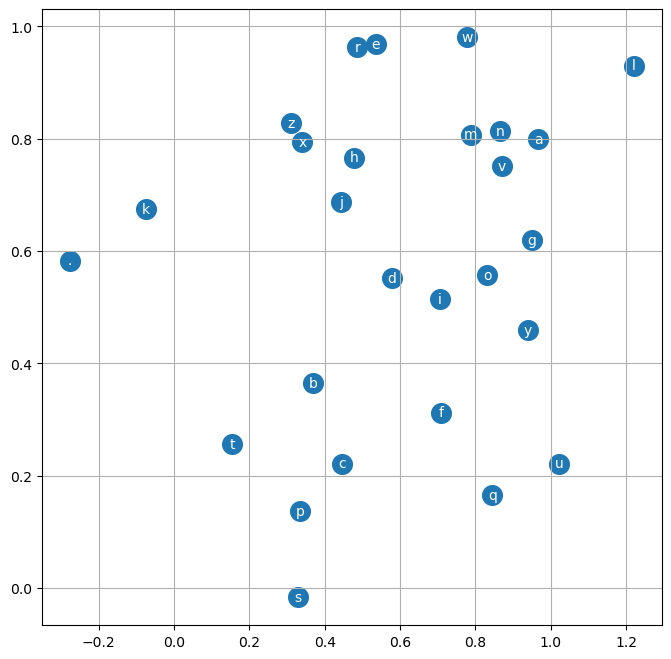

In [760]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

In [761]:
# training split, dev/validation split, test split
# 80% 10% 10%

In [762]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 5, 10])

In [768]:
# sample from the model
g = torch.Generator().manual_seed(2147482647 + 10)

block_size = 3

for _ in range(20):

    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

nyiad.
irug.
hen.
edeno.
nisekshaisence.
kand.
osperneihahnu.
hanklin.
juniah.
dynn.
dhairia.
ryliann.
mizier.
christi.
has.
disen.
azzia.
enviney.
avin.
miciana.
